In [2]:
import json
import os
import sys
import argparse
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy import stats
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import ks_2samp
src_dir = os.path.abspath(os.path.join(os.pardir, os.pardir,'src'))
sys.path[0] = src_dir
from parser.support import ROLES, CREDITS
from parser.my_mongo_db_login import DB_LOGIN_INFO
import parser.support as support
import network.network_builder as build
import generator.network_generator as net_gen

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [6]:
movie_producer_df = net_gen.open_movie_data()

Loaded IMDb movies producing_gender_percentage
Got all_movies


## plot colors

In [7]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return LinearSegmentedColormap.from_list(cmap_name, color_list, N)

viridis_cmap = discrete_cmap(20, 'viridis')


In [8]:
viridis_cmap = cm.viridis.colors

In [9]:
len(viridis_cmap)

256

# Building synthetic networks


* fixed values
    * number of movies per year
    * number of producers per year

* variables
    * number of people per team - producer_num_list
    * number of movies per producer - occurence_list
    * size of gaps - gap_list


In [10]:
unlistyfied_producer_df = net_gen.unlistify(movie_producer_df, 'producers')

In [11]:
number_of_movies_per_year = {}
for year, df in movie_producer_df.groupby('year'):
    number_of_movies_per_year[year] = len(df)

In [12]:
number_of_producers_per_year = {}
for year, df in unlistyfied_producer_df.groupby('year'):
    producers = list(set([i[0] for i in df.producers.tolist()]))
    number_of_producers_per_year[year] = len(producers)

In [13]:
num_producers_per_movie = {}
for year, df in movie_producer_df.groupby('year'):
    num_producers_per_movie[year] = [len(i) for i in df.producers.tolist()]

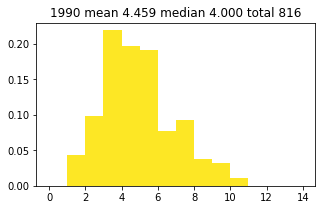

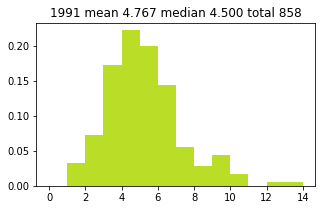

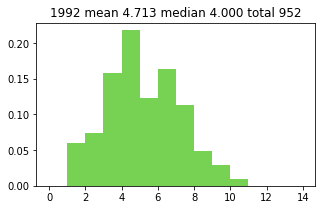

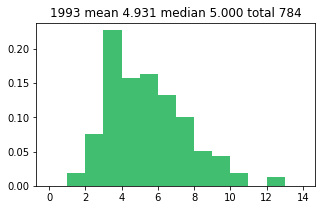

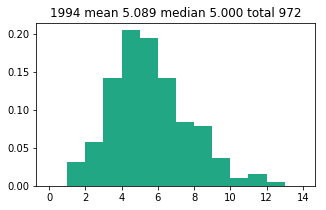

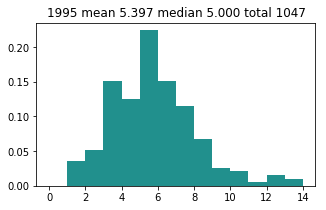

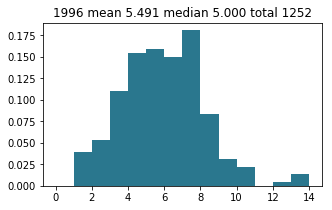

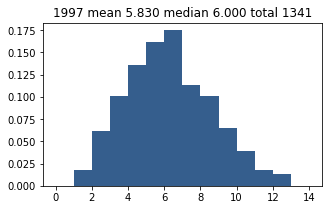

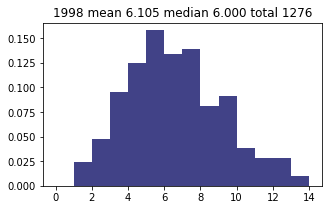

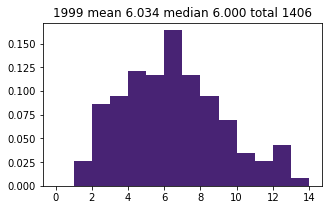

In [14]:
for year, num_producers in num_producers_per_movie.items():
    fig, ax = plt.subplots(figsize=(5,3))
    mean = np.mean(num_producers)
    median = np.median(num_producers)
    total = np.sum(num_producers)
    ax.hist(num_producers, bins=np.arange(0, 15,1), density=True, color=viridis_cmap[int(256*(2000-year)/10)-1])
    ax.set_title('{} mean {:.3f} median {:.3f} total {}'.format(year, mean, median, total))

In [15]:
year_list = []
median_list = []
low_ci_list = []
high_ci_list = []
for year, num_producers in num_producers_per_movie.items():
    median = np.median(num_producers)
    high_ci = np.percentile(num_producers, 97.5)
    low_ci = np.percentile(num_producers, 2.5)
    year_list.append(year)
    median_list.append(median)
    low_ci_list.append(low_ci)
    high_ci_list.append(high_ci)

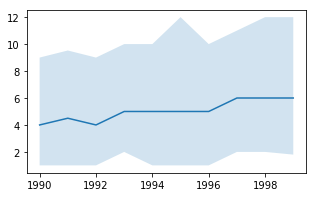

In [16]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(year_list, median_list)
ax.fill_between(year_list, low_ci_list, high_ci_list, alpha=0.2)

In [17]:
ks_2samp(num_producers_per_movie[1990], num_producers_per_movie[1996])

Ks_2sampResult(statistic=0.23547598504457867, pvalue=1.922157471278145e-05)

#### generate producer id

# Model 1

fixed number of movies, fixed number of producers

Everything else is random

In [58]:
year = 1990
movie_frame = movie_producer_df[movie_producer_df.year == year][['_id', 'producers', 'year', 'producer_num']]
num_producers = number_of_producers_per_year[year]
total_num_producers = len(list(set([i[0] for i in unlistyfied_producer_df.producers.tolist()])))

In [59]:
movie_frame['producers'] = ''

# Model 1- 0

fixed number of movies, fixed number of producers

team size round down/up of the mean

In [68]:
movie_frame_0 = movie_frame.copy(deep=True)

In [82]:
team_size_list = num_producers_per_movie[year]

In [70]:
mean_size = np.mean(team_size_list)
mean_ceil = np.ceil(mean_size)
mean_floor = np.floor(mean_size)

In [71]:
mean_size, mean_ceil, mean_floor

(4.459016393442623, 5.0, 4.0)

In [72]:
movie_frame_0['producer_num'] = movie_frame_0.apply(lambda x: random.choice([mean_ceil, mean_floor]))

In [73]:
movie_frame_0['producer_num'] = movie_frame_0.producer_num.apply(team_size, args=(mean_ceil, mean_floor))

In [76]:
generated_producers = generate_producers(total_num_producers)
years = total_movie_frame.year.unique().tolist()
year_assignment = assign_producers(generated_producers, years)

gen_producers_year = sample_producers(generated_producers, year, num_producers, year_assignment)

for i, row in movie_frame_0.iterrows():
    producers = np.random.choice(gen_producers_year, size=row.producer_num, replace=False)
    movie_frame_0.at[i, 'producers'] = producers

### Concat over the dataframe

In [80]:
len(generated_producers)

5758

In [75]:
total_movie_frame = movie_producer_df[['_id', 'producers', 'year', 'producer_num']].copy(deep=True)
total_movie_frame['producers'] = np.nan

In [79]:
num_schedules = 10
version_list = net_gen.make_version(num_schedules)

In [80]:
data_dir = '/home/projects/movie-network/data/synthetic_data/model_1_0/'



for i in range(num_schedules):
    #generate new producers every round
    generated_producers = generate_producers(total_num_producers)
    total_movie_frame = movie_producer_df[['_id', 'producers', 'year', 'producer_num']].copy(deep=True)
    total_movie_frame['producers'] = np.nan
    # assign years of any participation for every producer - every producer has to participate at least one year
    years = total_movie_frame.year.unique().tolist()
    year_assignment = assign_producers(generated_producers, years)
    for year, df in total_movie_frame.groupby('year'):
        print(year)
        num_producers = number_of_producers_per_year[year] #duplicate producers are already dropped
        mean_size = np.mean(df.producer_num.tolist())
        mean_ceil = np.ceil(mean_size)
        mean_floor = np.floor(mean_size)
        #choose number of producers for that year without replacement from the total pool
        print('sampling producers')
        gen_producers_year = sample_producers(generated_producers, year, num_producers, year_assignment)
        #fix the team size to its mean
        df['producer_num'] = df.producer_num.apply(team_size, args=(mean_ceil, mean_floor))
        #fill in the producers
        print('assign temas')
        producer_list = assign_team(gen_producers_year, df.producer_num.tolist())
        df['producers'] = producer_list
        total_movie_frame['producers'].update(df.producers)
        total_movie_frame['producer_num'].update(df.producer_num)
    total_movie_frame.to_json(os.path.join(data_dir, 'movies_1_0_{}.json'.format(version_list[i])), orient='split')


1990
sampling producers


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


assign temas


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1991
sampling producers


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


assign temas
1992
sampling producers


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

assign temas
1993
sampling producers
assign temas


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1994
sampling producers


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


assign temas
1995
sampling producers


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


assign temas
1996
sampling producers


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

assign temas
1997
sampling producers
assign temas


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1998
sampling producers


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


assign temas
1999
sampling producers


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


assign temas
1990
sampling producers


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


assign temas


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1991
sampling producers
assign temas


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1992
sampling producers


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

assign temas
1993
sampling producers
assign temas


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1994
sampling producers
assign temas


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1995
sampling producers


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

assign temas
1996
sampling producers
assign temas


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1997
sampling producers


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

assign temas
1998
sampling producers
assign temas


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1999
sampling producers


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


assign temas
1990
sampling producers
assign temas


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1991
sampling producers


/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

assign temas
1992
sampling producers
assign temas


KeyboardInterrupt: 

# Model 1-1

fixed number of movies, fixed number of producers

team size sampled from the real schedule

## Fill in producers

In [95]:
num_schedules = 10

version_list = []
while len(version_list) < num_schedules:
    ver = make_version()
    if ver not in version_list:
        version_list.append(ver)

In [ ]:
from os import listdir
from os.path import isfile, join

original_file_list = [join(original_dir, f) for f in listdir(original_dir) 
                       if isfile(join(original_dir, f))]

## Concat over multiple years

In [96]:
data_dir = '/home/projects/movie-network/data/synthetic_data/model_1_1/'

for i in range(num_schedules):
    #generate new producers every round
    generated_producers = generate_producers(total_num_producers)
    total_movie_frame = movie_producer_df[['_id', 'producers', 'year', 'producer_num']].copy(deep=True)
    total_movie_frame['producers'] = np.nan
    # assign years of any participation for every producer - every producer has to participate at least one year
    years = total_movie_frame.year.unique().tolist()
    year_assignment = assign_producers(generated_producers, years)
    for year, df in total_movie_frame.groupby('year'):
        num_producers = number_of_producers_per_year[year]
        gen_producers_year = sample_producers(generated_producers, year, num_producers, year_assignment)
        producer_list = assign_team(gen_producers_year, df.producer_num.tolist())
        df['producers'] = producer_list
        total_movie_frame['producers'].update(df.producers)
    total_movie_frame.to_json(os.path.join(data_dir, 'movies_1_1_{}'.format(version_list[i])), orient='split')

/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [93]:
gen_producer = [i for sublist in total_movie_frame[total_movie_frame.year==1991].producers.tolist() for i in sublist]
producer_1991 = [i[0] for sublist in movie_producer_df[movie_producer_df.year==1991].producers.tolist() for i in sublist]

In [102]:
import re

data_file = '/home/projects/movie-network/data/synthetic_data/model_1_0/movies_1_0_004195.json'

ver = re.findall(r'\d{6}', data_file)[0]
'_'.join([ver, '10'])

'004195_10'

# Problem

Random sampling does not account for all of the producers

###  See if sampling random number from 0-1 for total number of times is distributed

In [ ]:
years = total_movie_frame.year.unique().tolist()
sampling = np.random.choice(years, size=total_num_producers)
year_assignment = dict(zip(generated_producers, sampling))

In [ ]:
year = 1990

In [ ]:
baseline_producers = [p for p, y in year_assignment.items() if y == year ]

In [ ]:
non_baseline_producers = [p for p in generated_producers if p not in baseline_producers]

In [ ]:
num_producers = number_of_producers_per_year[year]
num_producers

In [ ]:
add_producers = np.random.choice(non_baseline_producers, size=num_producers-len(baseline_producers), replace=False)
len(list(set(baseline_producers + list(add_producers))))

In [ ]:
producers_1990 = get_producers(generated_producers, num_producers, year_assignment)
len(producers_1990)

### Assign gender

In [104]:
gender_df = support.get_staff_df('producers')[['_id', 'female_count', 'first_movie', 'last_movie', 'gender']]


In [108]:
females = build.generate_gender_seeds(gender_df)

In [113]:
len(females)

5572

In [111]:
original_producer_list = [i[0] for sublist in movie_90s.producers.tolist() for i in sublist]
seeds = [i for i in females if i in original_producer_list]
len(seeds)

1064

In [116]:
pd.read_json('/home/projects/movie-network/result/contagion/temporal/contagion_0_p10_d100_t100_ver_1.json', orient='split')

,year,0,1,2,3,4,5,6,7,8,...,252,253,254,255,256,257,258,259,260,261
0,1990,1064,1064,1064,1064,1064,1064,1064,1064,1064,...,1064,1064,1064,1064,1064,1064,1064,1064,1064,1064
1,1990,1067,1067,1067,1067,1067,1067,1065,1066,1064,...,1067,1067,1067,1067,1065,1064,1065,1066,1067,1064
2,1990,1067,1067,1067,1067,1067,1067,1065,1066,1064,...,1067,1067,1067,1067,1065,1064,1065,1066,1067,1064
3,1990,1068,1068,1067,1068,1067,1068,1066,1067,1065,...,1068,1068,1068,1068,1066,1065,1066,1067,1068,1065
4,1990,1070,1071,1070,1071,1069,1069,1067,1070,1067,...,1070,1071,1069,1070,1069,1067,1069,1068,1071,1068
5,1990,1070,1073,1073,1073,1072,1071,1067,1070,1070,...,1072,1072,1070,1073,1072,1068,1070,1069,1073,1071
6,1990,1070,1073,1073,1073,1072,1071,1067,1070,1070,...,1072,1072,1070,1073,1072,1068,1070,1069,1073,1071
7,1990,1070,1073,1073,1073,1072,1071,1067,1070,1070,...,1072,1072,1070,1073,1072,1068,1070,1069,1073,1071
8,1990,1071,1074,1074,1074,1072,1072,1068,1071,1071,...,1073,1073,1070,1074,1073,1069,1071,1070,1073,1072
9,1990,1071,1074,1074,1074,1072,1072,1068,1071,1071,...,1073,1073,1070,1074,1073,1069,1071,1070,1073,1072


In [168]:
df_density = pd.read_json('/home/staff/junelee/Desktop/contagion_1_p10_d100_t100_ver_003051_1.json', orient='split')

In [18]:
gender_df = support.get_staff_df('producers')[['_id', 'female_count', 'first_movie', 'last_movie', 'gender']]


In [145]:
unlistyfied_producer_df['gender'] = unlistyfied_producer_df.apply(lambda row: gender_df[gender_df._id == row.producers[0]].gender, axis=1)

In [154]:
unlistyfied_producer_df['gender'] = unlistyfied_producer_df.apply(assign_gender, args=(gender_df,), axis=1)

In [159]:
count_females = {}
for year, df in unlistyfied_producer_df.groupby('year'):
    females = []
    for i, row in df.iterrows():
        producer = row.producers[0]
        gender = row.gender
        if gender == 'female':
            if producer not in females:
                females.append(producer)
    count_females[year] = len(females)

In [157]:
gender_df[gender_df._id == 'nm0560370']

,_id,female_count,first_movie,last_movie,gender
3292,nm0560370,0,1989,1989,female


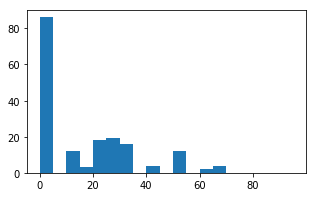

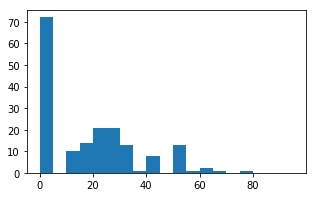

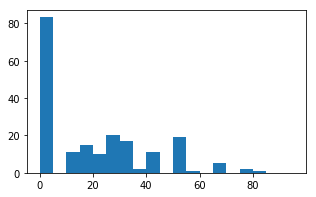

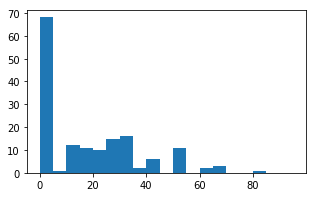

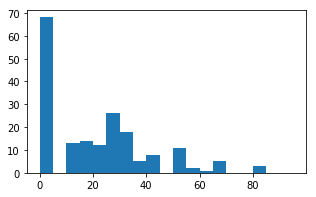

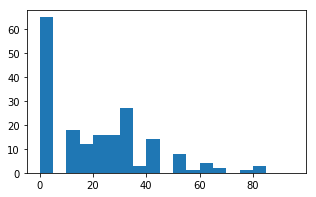

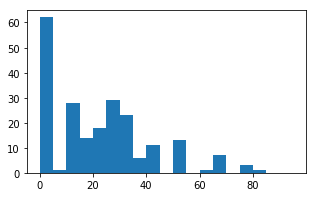

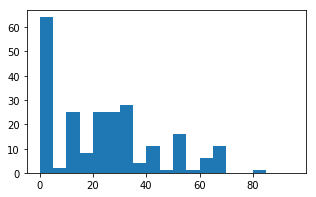

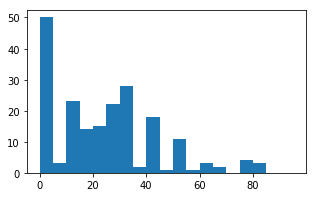

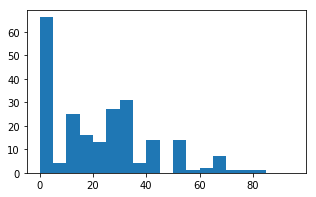

In [165]:
for year, df in movie_producer_df.groupby('year'):
    fig,ax = plt.subplots(figsize=(5,3))
    ax.hist(df.producing_gender_percentage, bins=np.arange(0,100,5))